In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simulation import *

from ipywidgets import interact, interactive, fixed, interact_manual, VBox
import ipywidgets as widgets

# Overview

There are four sections in this notebook

### 1. Simple interactive simulation
Simulate bias triangles with a total of 3 potential levels and few parameters

### 2. Complicated interactive simulation
Simulate bias triangles with a total of 5 potential levels. Also lets you control tunnel coupling between individual levels and drain/source tunneling rates.

### 3. Single random simulation
Draw random parameters and simulate a pair of bias triangles

### 4. Multiple random samples, comparing simulations with and without PSB
This is how the simulation will be used in the training of a classifier. We can see the comparison between a blocked and a unblocked arrangement for multiple random samples

# 1. Simple interactive simulation
For widgets to work you need to run 
```
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```
before starting the notebook. You can also run the cell below.

The simulation shows you the bias triangles on the left. On the right you can see how the potential levels align on the right. This reflects the situation at the red star in the left image.


### Noise
There are 4 elements of noise added:
- Gaussian blurring
- White noise
- Random charge jumps (between 0 and 2). Location and strength are also random
- Random jittering of potential levels at each pixel

In [2]:
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
def plot_bias_triangle(
    x=50,
    y=50,
    charging=0.5,
    leverleft=0.9,
    leverright=1.2,
    crosslr=0.2,
    crossrl=0.3,
    mu_s=0,
    mu_d=-1,
    temp=0.1,
    gamma_s=0.1,
    gamma_d=0.1,
    tc=0.05,
    shift=1,
    blank_space=0.3,
    gaussian_blur=0.1,
    jitter_var=0.01,
    in_psb=False,
    temp_broadening=True,
    adjust_voltage_window=True,
):
    params = {}
    params["voltage_bounds"] = [[-3, 1], [-3, 1]]
    params["n_points"] = [100, 100]
    params["dot1_pot_arrangement"] = np.array([0.0])
    params["dot2_pot_arrangement"] = np.array([0.0, charging])

    params["lever_arms"] = [leverleft, leverright]
    params["cross_talk"] = [crosslr, crossrl]
    params["mu_s"] = mu_s
    params["mu_d"] = mu_d
    params["temp"] = temp
    params["gamma_s"] = gamma_s
    params["gamma_d"] = gamma_d
    params["tc"] = tc
    params["jitter_var"] = jitter_var
    params["shift"] = shift
    params["temp_broadening"] = temp_broadening
    params["gaussian_blur"] = 1
    params["gaussian_blur"] = gaussian_blur
    params["white_noise_level"] = 5e-2

    params["in_psb"] = in_psb

    # print(blank_space)
    current = get_bias_triangles(
        params, blank_space=blank_space, adjust_voltage_window=adjust_voltage_window
    )

    temp = params["temp"]
    kT = 8.617e-5 * temp * 1e3
    n_points = params["n_points"]
    if adjust_voltage_window:
        voltage_bounds = get_voltage_extent(kT=kT, blank_space=blank_space, **params)
    else:
        voltage_bounds = params["voltage_bounds"]
    dot1_voltages = np.linspace(voltage_bounds[0][0], voltage_bounds[0][1], n_points[0])
    dot2_voltages = np.linspace(voltage_bounds[1][0], voltage_bounds[1][1], n_points[1])

    labels = []
    potlevels = []

    labels.append("source pot")
    potlevels.append(mu_s)

    dot1_pot_arrangement = params["dot1_pot_arrangement"]
    dot2_pot_arrangement = params["dot2_pot_arrangement"]

    dot1_base, dot2_base = get_base_pots(
        params, adjust_voltage_window=adjust_voltage_window, blank_space=blank_space
    )
    dot1_base += params["shift"]
    dot2_base += params["shift"]
    dot1_pots = dot1_base[:, :, np.newaxis] + dot1_pot_arrangement[np.newaxis, :]
    dot2_pots = dot2_base[:, :, np.newaxis] + dot2_pot_arrangement[np.newaxis, :]
    potential_levels0 = dot1_pots[y, x]
    potential_levels1 = dot2_pots[y, x]

    for val in potential_levels0:
        labels.append("leftdot")
        potlevels.append(val)
    for val in potential_levels1:
        labels.append("rightdot")
        potlevels.append(val)

    labels.append("drain pot")
    potlevels.append(mu_d)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.imshow(
        current[:, :], origin="lower", extent=(*voltage_bounds[0], *voltage_bounds[1])
    )
    ax1.scatter(dot1_voltages[x], dot2_voltages[y], s=200, c="tab:red", marker="*")
    ax2.scatter(labels, potlevels, marker="_")

    return ()


"""ip=interact(plot_bias_triangle,x=(1,100,1), y=(1,100,1),charging=(0.1,2,0.1,),
         leverleft=(0,2,0.1),leverright=(0,2,0.1), crosslr=(0,1,0.1),crossrl=(0,1,0.1),
         mu_s=(0,1,0.1), mu_d=(-1,0,0.1), temp=(0.01,2,0.1), 
         gamma_s=(0,1,0.1), gamma_d=(0,1,0.1),
         tc=(0,0.5,0.01), 
        blank_space=(0,1,0.1),shift=(0,1,0.1),jitter_var=(0,.1,0.01))"""

ip = interact(
    plot_bias_triangle,
    x=(1, 100, 1),
    y=(1, 100, 1),
    charging=(
        0.1,
        2,
        0.1,
    ),
    leverleft=(0, 2, 0.1),
    leverright=(0, 2, 0.1),
    crosslr=(0, 1, 0.1),
    crossrl=(0, 1, 0.1),
    mu_s=(0, 1, 0.1),
    mu_d=(-1, 0, 0.1),
    temp=(0.01, 2, 0.1),
    gamma_s=(0, 1, 0.1),
    gamma_d=(0, 1, 0.1),
    tc=(0, 0.5, 0.01),
    blank_space=(0, 1, 0.1),
    shift=(0, 10, 0.1),
    gaussian_blur=(0, 10, 1),
    jitter_var=(0, 0.1, 0.01),
)

interactive(children=(IntSlider(value=50, description='x', min=1), IntSlider(value=50, description='y', min=1)…

# Complicated interactive simulation

We added more potential levels (there are now 2 in the left dot and 3 in the right).
Here you get more control over the tunneling rates from the source and to the drain. You can also control the tunnel-coupling between each level.

In [4]:
def plot_bias_triangle(
    x=50,
    y=50,
    charging=0.4,
    leverleft=0.9,
    leverright=1.2,
    crosslr=0.2,
    crossrl=0.3,
    mu_s=0,
    mu_d=-1,
    temp=0.1,
    gamma_s=0.1,
    gamma_s2=0.3,
    gamma_d=0.1,
    gamma_d2=0.4,
    tc11=0.02,
    tc12=0.11,
    tc13=0.05,
    tc21=0.05,
    tc22=0.05,
    tc23=0.05,
    jitter_var=0.01,
    shift=1,
    blank_space=0.3,
    temp_broadening=True,
    in_psb=False,
):
    params = {}
    params["voltage_bounds"] = [[-3, 3], [-3, 3]]
    params["n_points"] = [100, 100]
    params["dot1_pot_arrangement"] = np.array([0.0, 2 * charging])  # ,1.5])
    params["dot2_pot_arrangement"] = np.array([0.0, charging, 2 * charging])

    params["lever_arms"] = [leverleft, leverright]
    params["cross_talk"] = [crosslr, crossrl]
    params["mu_s"] = mu_s
    params["mu_d"] = mu_d
    params["temp"] = temp
    params["gamma_s"] = [gamma_s, gamma_s2]
    params["gamma_d"] = [gamma_d, gamma_d2, gamma_d2]
    params["tc"] = np.array([[tc11, tc12, tc13], [tc21, tc22, tc23]])
    params["jitter_var"] = jitter_var
    params["shift"] = shift
    params["temp_broadening"] = temp_broadening
    params["gaussian_blur"] = 1
    params["white_noise_level"] = 5e-2
    params["in_psb"] = in_psb

    # print(blank_space)
    current = get_bias_triangles(params, blank_space=blank_space)

    temp = params["temp"]
    kT = 8.617e-5 * temp * 1e3
    n_points = params["n_points"]
    voltage_bounds = get_voltage_extent(kT=kT, blank_space=blank_space, **params)
    dot1_voltages = np.linspace(voltage_bounds[0][0], voltage_bounds[0][1], n_points[0])
    dot2_voltages = np.linspace(voltage_bounds[1][0], voltage_bounds[1][1], n_points[1])

    labels = []
    potlevels = []

    labels.append("source pot")
    potlevels.append(mu_s)

    dot1_pot_arrangement = params["dot1_pot_arrangement"]
    dot2_pot_arrangement = params["dot2_pot_arrangement"]

    dot1_base, dot2_base = get_base_pots(
        params, adjust_voltage_window=True, blank_space=blank_space
    )
    dot1_base += params["shift"]
    dot2_base += params["shift"]
    dot1_pots = dot1_base[:, :, np.newaxis] + dot1_pot_arrangement[np.newaxis, :]
    dot2_pots = dot2_base[:, :, np.newaxis] + dot2_pot_arrangement[np.newaxis, :]
    potential_levels0 = dot1_pots[y, x]
    potential_levels1 = dot2_pots[y, x]

    for val in potential_levels0:
        labels.append("leftdot")
        potlevels.append(val)

    for val in potential_levels1:
        labels.append("rightdot")
        potlevels.append(val)

    labels.append("drain pot")
    potlevels.append(mu_d)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.imshow(
        current[:, :], origin="lower", extent=(*voltage_bounds[0], *voltage_bounds[1])
    )
    ax1.scatter(dot1_voltages[x], dot2_voltages[y], s=200, c="tab:red", marker="*")
    ax2.scatter(labels, potlevels, marker="_")

    return ()


ip = interact(
    plot_bias_triangle,
    x=(1, 100, 1),
    y=(1, 100, 1),
    charging=(
        0.1,
        2,
        0.1,
    ),
    leverleft=(0, 2, 0.1),
    leverright=(0, 2, 0.1),
    crosslr=(-1, 1, 0.1),
    crossrl=(-1, 1, 0.1),
    mu_s=(0, 1, 0.1),
    mu_d=(-1, 0, 0.1),
    temp=(0.01, 2, 0.01),
    gamma_s=(0, 1, 0.1),
    gamma_s2=(0, 1, 0.1),
    gamma_d=(0, 1, 0.1),
    gamma_d2=(0, 1, 0.1),
    tc11=(0, 0.5, 0.01),
    tc12=(0, 0.5, 0.01),
    tc13=(0, 0.5, 0.01),
    tc21=(0, 0.5, 0.01),
    tc22=(0, 0.5, 0.01),
    tc23=(0, 0.5, 0.01),
    jitter_var=(0, 1, 0.01),
    blank_space=(0, 1, 0.1),
    shift=(0, 1, 0.1),
)

interactive(children=(IntSlider(value=50, description='x', min=1), IntSlider(value=50, description='y', min=1)…

# Single random sample

Now we sample random parameters and simulate accordingly

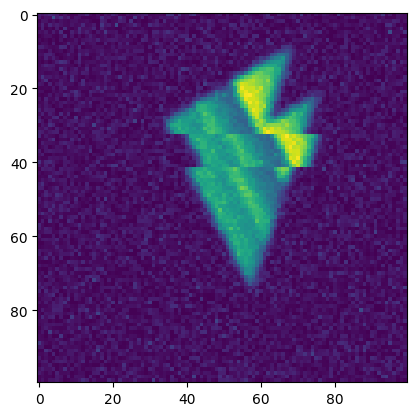

{'tc': array([[0.27865325, 0.12504445, 0.05538334, 0.18463306],
       [0.17433527, 0.06855437, 0.11902737, 0.19375261],
       [0.19201992, 0.18817915, 0.11017578, 0.28844014]]), 'gamma_s': array([0.13745552, 0.02318566, 0.0516619 ]), 'gamma_d': array([0.47469208, 0.44592164, 0.16044351, 0.45132793]), 'mu_s': -0.21711927564746425, 'mu_d': -1.4748313881365676, 'temp': 0.5459198346113202, 'lever_arms': array([1.23539057, 0.80683889]), 'cross_talk': array([0.42179931, 0.48498475]), 'shift': 0.42612380485947, 'dot1_pot_arrangement': array([ 0.        , -1.43906327, -2.36325858]), 'dot2_pot_arrangement': array([0.        , 0.28592046, 0.52747598, 0.83524317]), 'in_psb': True, 'jitter_var': 0.006423909485096746, 'gaussian_blur': 1.019894744076021, 'white_noise_level': 0.062010769908097015, 'n_points': [100, 100]}


In [5]:
params = sample_factors()
params["n_points"] = [100, 100]
current = get_bias_triangles(params, blank_space=0.3)
plt.imshow(current)
plt.show()
print(params)

# Multiple random samples, comparing simulations with and without PSB

Here you can sample the training data for a PSB detector. Each sample contains two simulation, one without PSB (at index 1) and one the is possibly in PSB (at index 0) according to the randomly sampled parameters.

  0%|          | 0/10 [00:00<?, ?it/s]

Sample index 0
PSB? True


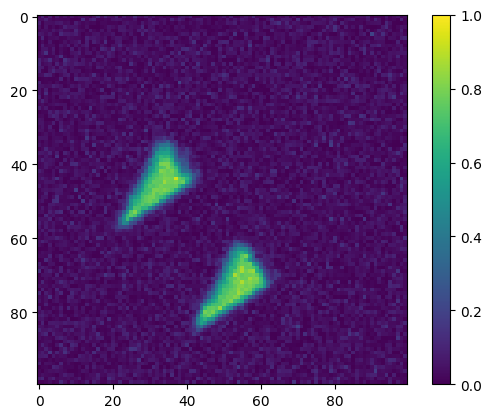

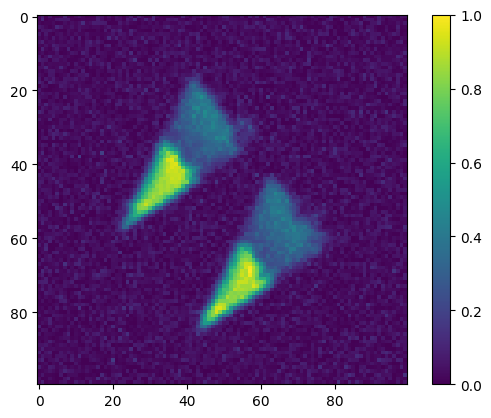

Sample index 1
PSB? True


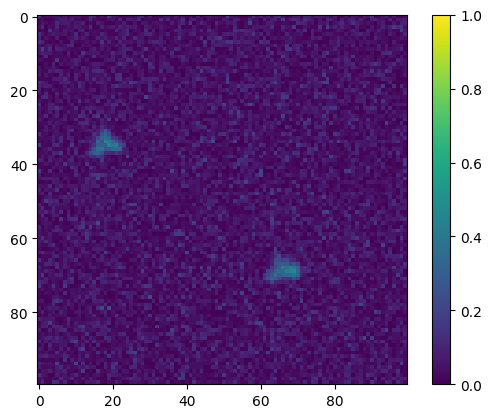

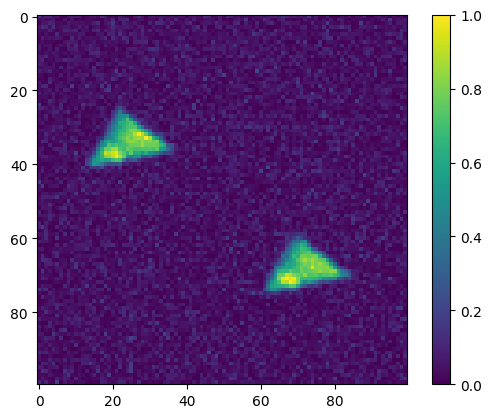

Sample index 2
PSB? False


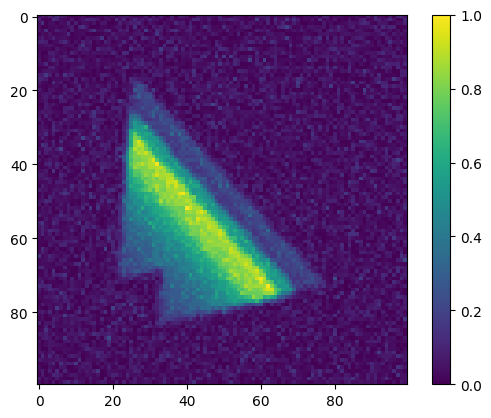

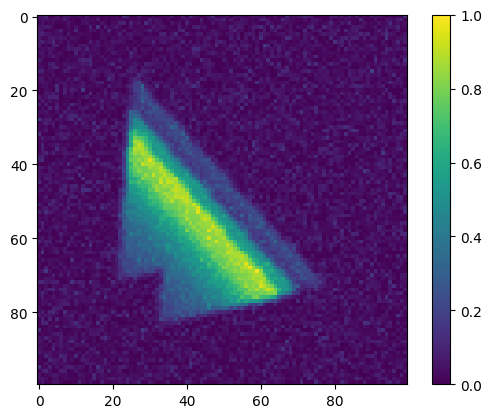

Sample index 3
PSB? False


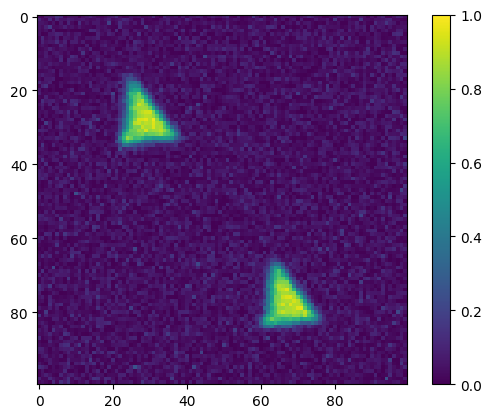

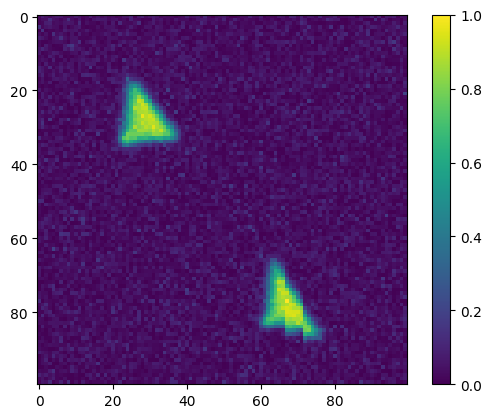

Sample index 4
PSB? True


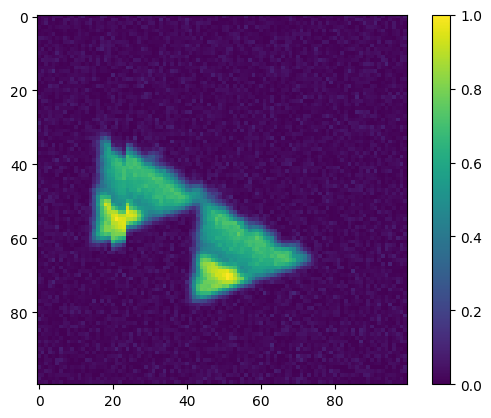

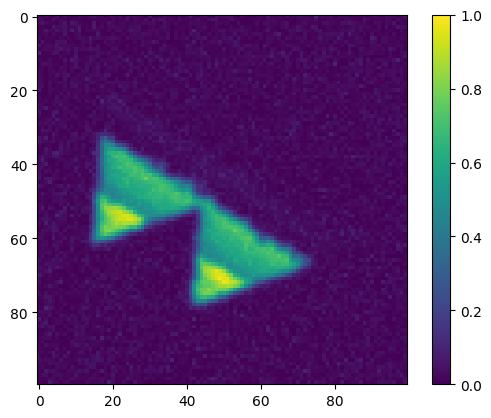

Sample index 5
PSB? True


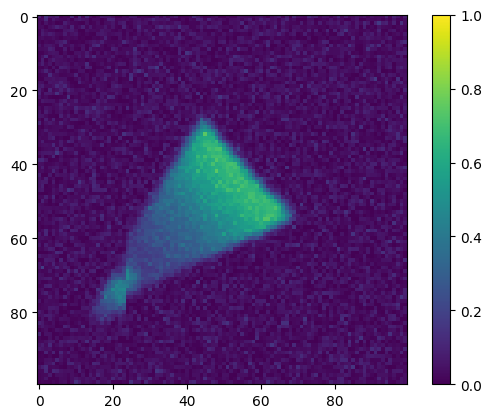

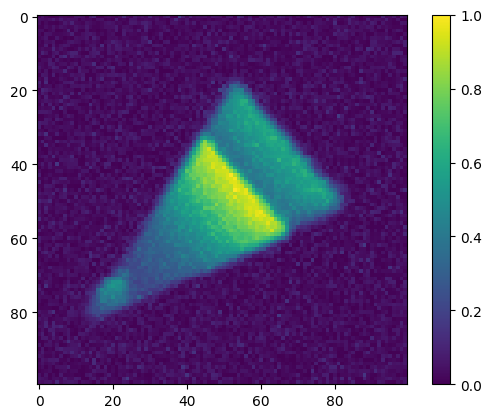

Sample index 6
PSB? False


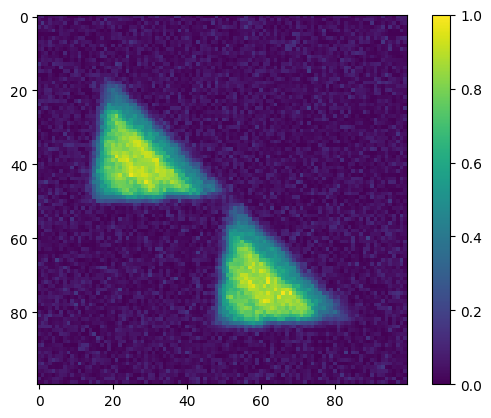

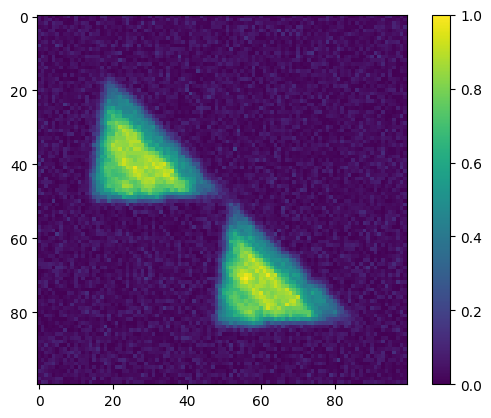

Sample index 7
PSB? False


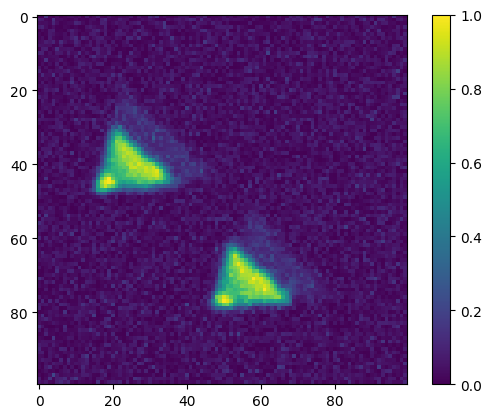

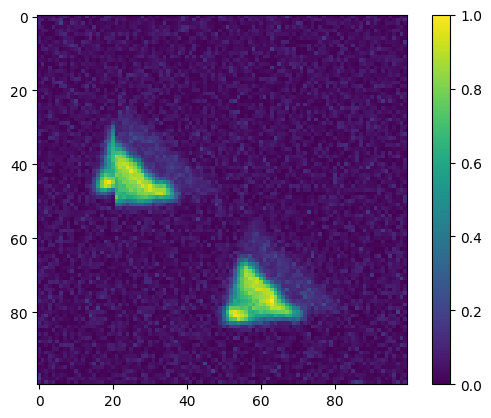

Sample index 8
PSB? True


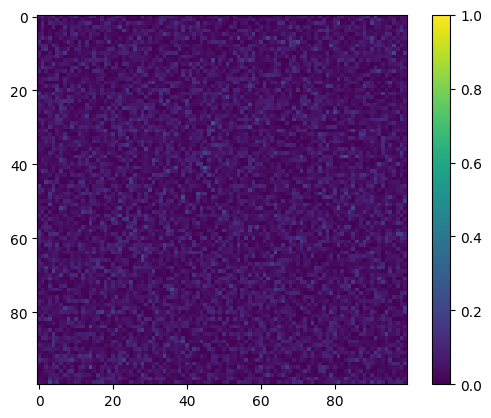

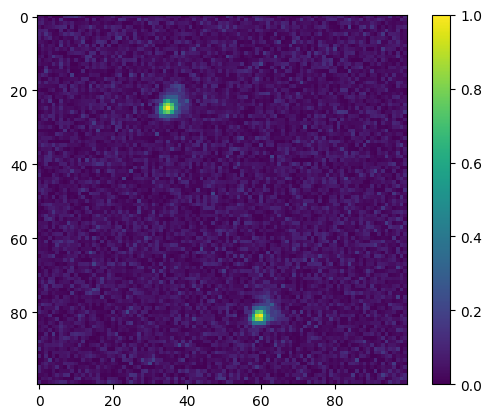

Sample index 9
PSB? False


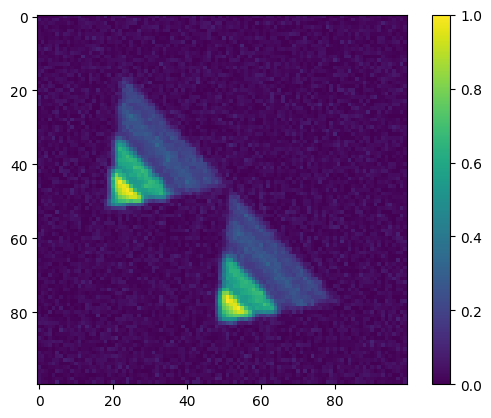

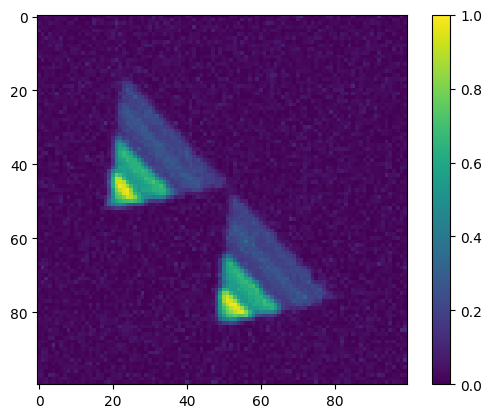

In [6]:
n_samples = 10
samples, labels = simulate(n_samples)

for i, sample in enumerate(samples):
    print("Sample index", i)
    print("PSB?", labels[i])
    sample = normalise(sample)
    plt.imshow(sample[0])
    plt.colorbar()
    plt.clim(0, 1)
    plt.show()
    plt.imshow(sample[1])
    plt.colorbar()
    plt.clim(0, 1)
    plt.show()